#### August 18, 2016 - Women in Data Science ATX Meetup - "Data Science from Scratch" Workshop #6

# Hypothesis Testing on the Titanic Data Set with Python

## 0. Preliminaries

### 0.1 Load Python modules

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import probplot,chi2_contingency

sns.set_style('white') #let's make everything look pretty
%matplotlib inline

In [33]:
# Print version info
import sys
import matplotlib as mpl
import scipy
print("python " + sys.version)
print("")
print("pandas " + str(pd.__version__))
print("numpy " + np.__version__)
print("matplotlib " + mpl.__version__)
print("seaborn " + sns.__version__)
print("scipy "+scipy.__version__)

python 2.7.11 |Continuum Analytics, Inc.| (default, Feb 16 2016, 09:58:36) [MSC v.1500 64 bit (AMD64)]

pandas 0.18.1
numpy 1.10.1
matplotlib 1.5.0
seaborn 0.6.0
scipy 0.16.0


__Load and combine the train and test data.__

In [3]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
full=pd.concat([test,train]) #combine the sets vertically--align columns
full.describe()

C:\Users\Samruddhi Somani\Desktop\mystuff\mc\lib\site-packages\numpy\lib\function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,328.000000,2.000000,0.000000,NaN
50%,NaN,NaN,0.000000,655.000000,3.000000,0.000000,NaN
75%,NaN,NaN,0.000000,982.000000,3.000000,1.000000,NaN
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


## 1. Set the hypotheses

__Null Hypothesis__: $H_O$ that represents some default position  
__Alternative Hypothesis__: $H_A$ that we compare with $H_O$

## 2. Check assumptions and conditions

a. Independence:
- _Within Groups: Sampled observations must be independent within each group._ 
    - Random sample/assignment
    - If sampling without replacement, n<10% of total population  
- _Between Groups: Two groups must be independent of each other (non-paired)_

b. *Sample size/skew: Each sample should meet the success-failure condition:*
    $$n_{\rm child} p_{\rm child} \ge 10 \quad \textrm{and} \quad n_{\rm child} (1 - p_{\rm child}) \ge 10$$
    $$n_{\rm adult} p_{\rm adult} \ge 10 \quad \textrm{and} \quad n_{\rm adult} (1 - p_{\rm adult}) \ge 10$$
    

### Check independence.
1.We see from the above describe that we only have ages for 1046 of the 1309 total passengers. We can scale these figures to the entire dataset.

In [4]:
# select 4 columns of data frame
# deep copy means make an actual copy in memory instead of a slice
full_trim = full[['Survived', 'Age', 'Sex', 'Pclass']].copy(deep=True) 

2.We see that the ages are right skewed, although there is a noticeable dip in the number of teenagers and bump in young adults.

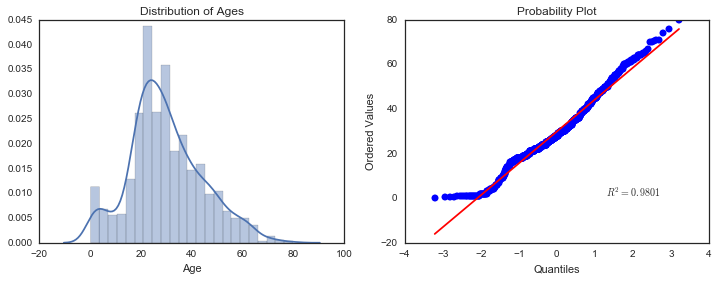

In [5]:
#generating layout
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,4)

#plot the histogram plus density estimation
age_plotting=full_trim.loc[full_trim['Age'].notnull(),'Age'] #sns doesn't handle nan's
sns.distplot(age_plotting,ax=ax1)
ax1.set_title("Distribution of Ages")

#plot the quantile plot
x=probplot(age_plotting,plot=ax2)

3.Let's discretize age into child versus adult. We can scale those back up to determine how big our samples should be. 

In [6]:
def agegroup(x):
    '''
    I determine the appropriate age group for a particular passenger
    '''
    if np.isnan(x):
        return (np.nan)
    elif x<18:
        return("Child")
    else:
        return("Adult")

full_trim['AgeGroup']=full_trim['Age'].apply(agegroup)
full_trim['AgeGroup'].value_counts()

Adult    892
Child    154
Name: AgeGroup, dtype: int64

In [7]:
full_trim['AgeGroup'].value_counts()*(1317.0/1046.0)
#scale by factor of total data count over data rows with ages (Zeros force float calculations)

Adult    1123.101338
Child     193.898662
Name: AgeGroup, dtype: float64

4.Estimate the number of children as 194 and adults as 1123. Thus our sample sizes should be less than 19 for children and less than 112 for adults to meet the 10% criterion for independence.

5.Take a subset of training set rows with ages (for which we have survival data). A sample size of 100 fits our 10% condition for independence.

In [21]:
sample=train.ix[train['Age'].notnull()].sample(100,random_state=100)
sample['AgeGroup']=sample['Age'].apply(agegroup)
sample['AgeGroup'].value_counts()

Adult    84
Child    16
Name: AgeGroup, dtype: int64

6.Build contingency tables.

In [22]:
#create a new column that transforms the survived columns to labels
survival_dict={1:'Yes',0:'No'}
sample['Lived']=sample['Survived'].map(survival_dict)

In [23]:
#how many people from our sample lived
sample['Lived'].value_counts()

No     69
Yes    31
Name: Lived, dtype: int64

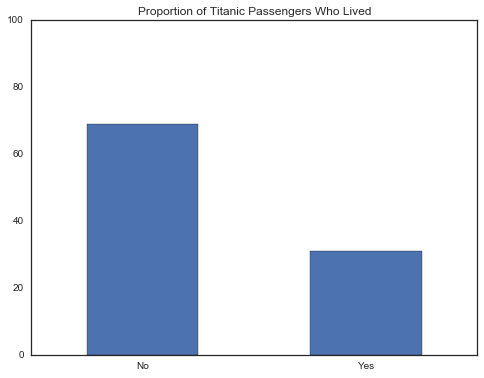

In [24]:
#let's make a plot for fun
sample['Lived'].value_counts().plot(kind="bar",
                                        ylim=(0,100),
                                        rot=0,
                                        title="Proportion of Titanic Passengers Who Lived",
                                        figsize=(8,6))

### Check sample size/skew.

1.Build frequency tables.

In [46]:
lived=pd.crosstab(index=sample['AgeGroup'],
            columns=sample['Lived'])
lived

Lived,No,Yes
AgeGroup,,
Adult,62,22
Child,7,9


In [47]:
lived_proportions=pd.crosstab(index=sample['AgeGroup'],
            columns=sample['Lived'],
            margins=True)
lived_proportions

Lived,No,Yes,All
AgeGroup,,,
Adult,62,22,84
Child,7,9,16
All,69,31,100


## 4. Make a decision, and interpret it in the context of the research question.

1.Calculate chi-squared

In [49]:
ch,p=chisquare(lived)
p

array([  3.56241675e-11,   1.95502691e-02])